In [1]:
!pip install cirq

In [2]:
import cirq
import cirq_google
import matplotlib.pyplot as plt

In [3]:

q0, q1 = cirq.LineQubit.range(2)
ancilla = cirq.NamedQubit("Ancilla")

def make_oracle(qubits, ancilla):
    return cirq.TOFFOLI(qubits[0], qubits[1], ancilla)

# Función para una iteración de Grover
def grover_iteration(qubits, ancilla, oracle):
    circuit = cirq.Circuit()

    # 1. Superposición inicial
    circuit.append(cirq.H.on_each(*qubits))

    # 2. Preparar ancilla en |->
    circuit.append([cirq.X(ancilla), cirq.H(ancilla)])

    # 3. Aplicar oracle
    circuit.append(oracle)

    # 4. Difusor (inversión sobre la media)
    circuit.append(cirq.H.on_each(*qubits))
    circuit.append(cirq.X.on_each(*qubits))
    circuit.append(cirq.H(qubits[1]))
    circuit.append(cirq.CNOT(qubits[0], qubits[1]))
    circuit.append(cirq.H(qubits[1]))
    circuit.append(cirq.X.on_each(*qubits))
    circuit.append(cirq.H.on_each(*qubits))

    # 5. Medición
    circuit.append(cirq.measure(*qubits, key='result'))

    return circuit

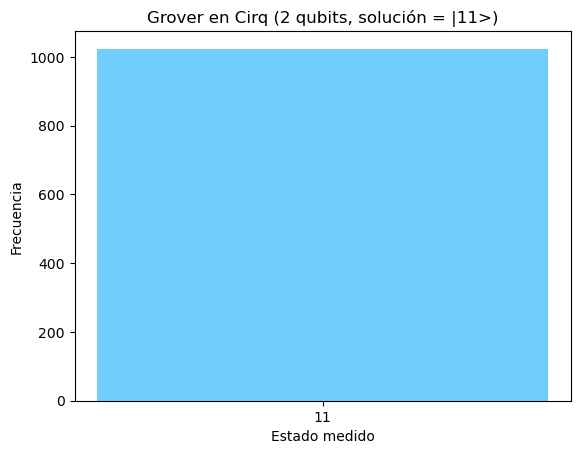

Resultados de la medición: {'11': 1024}


In [4]:
# Crear el oracle
oracle = make_oracle([q0, q1], ancilla)
circuit = grover_iteration([q0, q1], ancilla, oracle)
# Simulación
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=1024)

# Contar resultados
counts = result.histogram(key='result')
labels = [f"{b:02b}" for b in counts.keys()]

# Dibujar histograma
plt.bar(labels, counts.values(), color="#70CEFF")
plt.xlabel("Estado medido")
plt.ylabel("Frecuencia")
plt.title("Grover en Cirq (2 qubits, solución = |11>)")
plt.show()

# Mostrar resultados
print("Resultados de la medición:", dict(zip(labels, counts.values())))


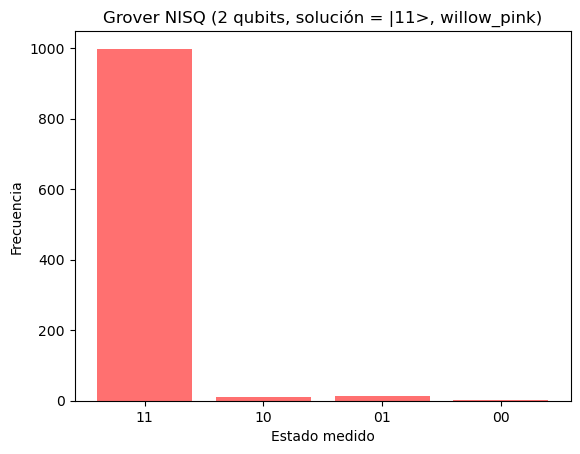

Resultados de la medición con ruido realista: {'11': 998, '10': 11, '01': 12, '00': 3}


In [9]:
# --- Qubits: usar los qubits del procesador virtual ---
# Tomamos los primeros 3 qubits que figuran en noise_props
processor_id = "willow_pink"
noise_props = cirq_google.engine.load_device_noise_properties(processor_id)
qubits_list = list(noise_props.qubits)[:3]  # necesitamos 2 input + 1 ancilla
q0, q1, ancilla = qubits_list

# --- Oracle para |11> usando Toffoli ---
def make_oracle(qubits, ancilla):
    return cirq.TOFFOLI(qubits[0], qubits[1], ancilla)

# --- Construir circuito ---
oracle = make_oracle([q0, q1], ancilla)
circuit = grover_iteration([q0, q1], ancilla, oracle)

# --- Crear NoiseModel desde las propiedades del procesador ---
noise_model = cirq_google.NoiseModelFromGoogleNoiseProperties(noise_props)

# --- Simulación con ruido realista ---
simulator = cirq.DensityMatrixSimulator(noise=noise_model)
result = simulator.run(circuit, repetitions=1024)

# --- Contar resultados ---
counts = result.histogram(key='result')
labels = [f"{b:02b}" for b in counts.keys()]

# --- Dibujar histograma ---
plt.bar(labels, counts.values(), color="#FF7070")
plt.xlabel("Estado medido")
plt.ylabel("Frecuencia")
plt.title(f"Grover NISQ (2 qubits, solución = |11>, {processor_id})")
plt.show()

# --- Resultados ---
print("Resultados de la medición con ruido realista:", dict(zip(labels, counts.values())))


In [7]:
results_dict = dict(zip(labels, counts.values()))
expected_result = "11"  # estado objetivo de Grover
shots = sum(counts.values())
hits = results_dict.get(expected_result, 0)
fidelity = hits / shots

print(f"Fidelidad clásica respecto al estado objetivo '{expected_result}': {fidelity:.4f}")


Fidelidad clásica respecto al estado objetivo '11': 0.9697
